### **This Aims to Iteratively find the Best Cleaning Parameters based on GroupKFold Accuracy**

#### **This version performas grid search in parralel so may require better hardware.**

\*This was eventually superceded by the Optuna searches, so that a wider set of parameters could be tested.\*

Import Libraries

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.signal import peak_widths, peak_prominences
from sklearn.model_selection import GroupKFold, cross_validate
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score

Read the spectral data

In [2]:
#df = pd.read_csv("../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../data/current_clean_spectrum.csv", index_col=0)
df = pd.read_csv("../data/current_clean_spectrum.csv")

In [3]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,32.316184
1,201210-1-00,294,400.91116,201210-1,Normal,32.229535
2,201210-1-00,295,401.59454,201210-1,Normal,32.142799
3,201210-1-00,296,402.27789,201210-1,Normal,32.055975
4,201210-1-00,297,402.96127,201210-1,Normal,31.969064
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-16.873032
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-15.976760
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-15.040871
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-14.065367


#### **1 Sample Visualisation**

In [4]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber     SurID         Status  Absorbance
6206421  210526-3-04   293   400.22778  210526-3  Hyperglycemia   37.657474
6206422  210526-3-04   294   400.91116  210526-3  Hyperglycemia   35.609384
6206423  210526-3-04   295   401.59454  210526-3  Hyperglycemia   33.643726
6206424  210526-3-04   296   402.27789  210526-3  Hyperglycemia   31.760500
6206425  210526-3-04   297   402.96127  210526-3  Hyperglycemia   29.959707
...              ...   ...         ...       ...            ...         ...
6208465  210526-3-04  2337  1797.03870  210526-3  Hyperglycemia  -26.954993
6208466  210526-3-04  2338  1797.72200  210526-3  Hyperglycemia  -25.754306
6208467  210526-3-04  2339  1798.40550  210526-3  Hyperglycemia  -24.498900
6208468  210526-3-04  2340  1799.08890  210526-3  Hyperglycemia  -23.188775
6208469  210526-3-04  2341  1799.77220  210526-3  Hyperglycemia  -21.823931

[2049 rows x 6 columns]


Find Peaks Within the spectrum.

In [5]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)
peaks, _ = find_peaks(x=sample['Absorbance'])

c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

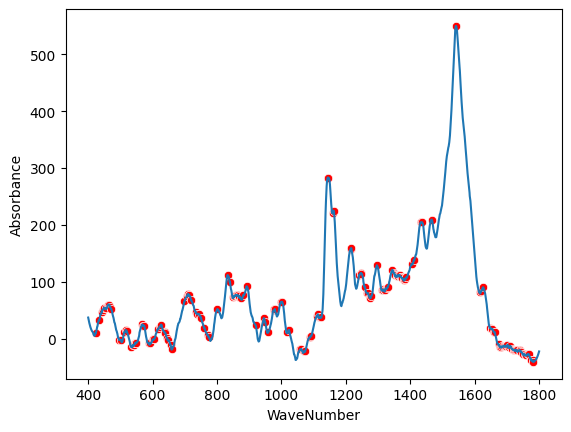

In [6]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peaks], x="WaveNumber", y="Absorbance", color="red")

As you can see, it does not properly find the peaks, so we have to tune the peak finding parameters.

These parameters are based on Thomas Keogh's Search

In [7]:
tuned_peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

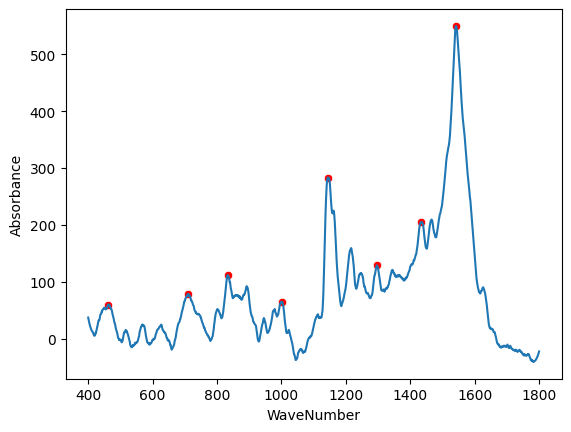

In [8]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[tuned_peaks], x="WaveNumber", y="Absorbance", color="red")

---

#### **Find the best Peak Finding Parameters**

Create a field for each wavelength.

Train an Extra Trees Classifier

In [9]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

#### **1. Using Peak Statistics**

In [10]:
backup = df

In [11]:
statuses = df[['SpecID', 'Status','SurID']].drop_duplicates()

This uses statistical properties of the peaks in each sample to be used as additional features.

In [12]:
peaks = []
widths = []
prominences = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])


    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_14808\3839389258.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
C:\Users\FX 8320\AppData\Local\Temp\ipykernel_14808\3839389258.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [13]:
peaks_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences
27,201210-1-00,320,418.67880,201210-1,Normal,30.732150,2.023924,1.198330
32,201210-1-00,325,422.09567,201210-1,Normal,31.021123,3.424388,2.095752
35,201210-1-00,328,424.14578,201210-1,Normal,30.601763,1.050242,0.525987
40,201210-1-00,333,427.56265,201210-1,Normal,30.741096,2.161475,0.866607
44,201210-1-00,337,430.29614,201210-1,Normal,29.745126,0.679559,0.383077
...,...,...,...,...,...,...,...,...
6228912,210526-3-49,2294,1767.65380,210526-3,Hyperglycemia,-9.913568,0.676075,0.195040
6228919,210526-3-49,2301,1772.43740,210526-3,Hyperglycemia,-9.642451,3.240271,1.831359
6228928,210526-3-49,2310,1778.58760,210526-3,Hyperglycemia,-13.323386,1.523689,0.203017
6228932,210526-3-49,2314,1781.32120,210526-3,Hyperglycemia,-13.558435,2.228706,0.672524


In [14]:
#sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue='Status')

Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [15]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [16]:
# # Create a new DataFrame for the summary statistics
# peak_stats = peaks_df.groupby('SpecID').agg({
#     'PeakWidths': ['mean', 'std', 'max', 'min'],
#     'PeakProminences': ['mean', 'std', 'max', 'min']
# }).reset_index()

# # Flatten the multi-level columns and customize the names
# peak_stats.columns = ['SpecID',
#                       'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
#                       'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

Sometimes not every sample has a peak.

In [17]:
peak_stats.head()

,SpecID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
0,201210-1-00,31.279607,33.560303,227,158.758043,-24.423398,5.375905,17.973687,200.649197,0.501422,4.344912,19.025671,168.337399,0.002454
1,201210-1-01,35.357959,42.721307,183,192.279823,-32.818701,5.997009,17.184534,156.797333,0.502137,6.770275,27.694290,209.668053,0.004513
2,201210-1-02,68.144182,129.670610,156,1362.987660,-78.303377,5.476485,11.879807,67.002894,0.501579,19.772493,124.622732,1399.333808,0.002079
3,201210-1-03,104.513055,187.366552,130,980.879264,-122.220644,5.873965,12.522514,65.289975,0.502592,32.716991,151.958481,1041.990373,0.006251
4,201210-1-04,61.004110,68.467508,203,306.811288,-54.620683,5.738324,19.360304,199.468962,0.502457,6.550225,31.282741,362.928379,0.002474


In [18]:
peak_stats.shape

(3045, 14)

In [19]:
peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(0)

In [20]:
peak_stats.shape

(3045, 15)

In [21]:
peak_stats.head()

,Status,SurID,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min
SpecID,,,,,,,,,,,,,,,
201210-1-00,Normal,201210-1,31.279607,33.560303,227,158.758043,-24.423398,5.375905,17.973687,200.649197,0.501422,4.344912,19.025671,168.337399,0.002454
201210-1-01,Normal,201210-1,35.357959,42.721307,183,192.279823,-32.818701,5.997009,17.184534,156.797333,0.502137,6.770275,27.694290,209.668053,0.004513
201210-1-02,Normal,201210-1,68.144182,129.670610,156,1362.987660,-78.303377,5.476485,11.879807,67.002894,0.501579,19.772493,124.622732,1399.333808,0.002079
201210-1-03,Normal,201210-1,104.513055,187.366552,130,980.879264,-122.220644,5.873965,12.522514,65.289975,0.502592,32.716991,151.958481,1041.990373,0.006251
201210-1-04,Normal,201210-1,61.004110,68.467508,203,306.811288,-54.620683,5.738324,19.360304,199.468962,0.502457,6.550225,31.282741,362.928379,0.002474


In [22]:
evaluate_extra_trees(peak_stats)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4205 +/- 0.0932


##### **Find the best Peak Finding Parameters for the Stat Based Approach**

In [23]:
df = df.drop(columns=['Seq', 'SurID'])

In [24]:
df

,SpecID,WaveNumber,Status,Absorbance
0,201210-1-00,400.22778,Normal,32.316184
1,201210-1-00,400.91116,Normal,32.229535
2,201210-1-00,401.59454,Normal,32.142799
3,201210-1-00,402.27789,Normal,32.055975
4,201210-1-00,402.96127,Normal,31.969064
...,...,...,...,...
6239200,210526-3-09,1797.03870,Hyperglycemia,-16.873032
6239201,210526-3-09,1797.72200,Hyperglycemia,-15.976760
6239202,210526-3-09,1798.40550,Hyperglycemia,-15.040871
6239203,210526-3-09,1799.08890,Hyperglycemia,-14.065367


In [25]:
# Define parameter ranges

## Test Search
# distances = [None, 5]
# prominences = [None, 0.01]
# widths = [None, 5]
# thresholds = [None, 0.01]

# First Search
distances = [None, 5, 10, 25, 50, 100, 150, 200, 250]
prominences = [None, 5, 10, 25, 50, 100, 150, 200, 250]
widths = [None, 0.5, 1, 2, 3, 4, 5, 8]
thresholds = [None, 5, 10, 25, 50]

In [26]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Ignore UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [27]:
def preprocess_and_extract_peaks(df, distance, prominence, width, threshold):
    
    widths = []
    prominences = []
    peaks = []
    
    for _, group in df.groupby('SpecID'):

        peak_index, _ = find_peaks(x=group['Absorbance'], distance=distance, prominence=prominence, width=width, threshold=threshold)

        # Calculate the widths of each peak
        widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

        # Calculate prominence of each peak
        prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

        # Find the index of the peak within the full dataframe
        peaks += list(group.iloc[peak_index].index.values)

    peaks_df = df.loc[peaks].copy()
    peaks_df['PeakWidths'] = widths
    peaks_df['PeakProminences'] = prominences
    return peaks_df

In [28]:
def evaluate_model_with_cross_validation(df, distance, prominence, width, threshold):
    
    df_copy = df.copy()
    peaks_df = preprocess_and_extract_peaks(df_copy, distance, prominence, width, threshold)

    # Average peak count per spectrum
    avg_peak_count = len(peaks_df)/3045

    # Create a new DataFrame for the summary statistics
    peak_stats = peaks_df.groupby('SpecID').agg({
        'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
        'PeakWidths': ['mean', 'std', 'max', 'min'],
        'PeakProminences': ['mean', 'std', 'max', 'min']
    }).reset_index()

    # Flatten the multi-level columns and customise the names
    peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']
    
    # Add the statuses back to the dataframe
    peak_stats = pd.merge(statuses, peak_stats, on='SpecID', how='left').set_index('SpecID').fillna(0)

    X = peak_stats.drop(['Status', 'SurID'], axis=1)
    y = peak_stats['Status']
    groups = peak_stats['SurID']
    
    et = ExtraTreesClassifier(random_state=1234)
    cv = GroupKFold(n_splits=10)
    
    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    
    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
        }

# Parallel execution
results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

# results = []
# for d in distances:
#     for p in prominences:
#         for w in widths:
#             for t in thresholds:
#                 results.append(evaluate_model_with_cross_validation(df, d, p, w, t))

In [29]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best parameters based on the selected criteria
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"Best Parameters: Distance={best_row['Distance']}, Prominence={best_row['Prominence']}, Width={best_row['Width']}, Thresholde={best_row['Threshold']} and Avg_Peak_Count={best_row['Average Peak Count']:.2f} with Accuracy: {best_row['Accuracy']:.4f}")

# Save the results to csv
results_df.sort_values('Accuracy', ascending=False).to_csv("../data/Peak_Stat_Parameters.csv", index=False)

Best Parameters: Distance=10.0, Prominence=nan, Width=nan, Thresholde=nan and Avg_Peak_Count=73.63 with Accuracy: 0.4223


#### **2. Creating a uniform Peak Featureset**

This aims to create a featureset using peaks within wavenumber intervals.

Assign Peaks to bins of a fixed wavelength interval.

In [30]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

In [31]:
# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_14808\3718610318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [32]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PeakWidths,PeakProminences,Bin
27,201210-1-00,320,418.67880,201210-1,Normal,30.732150,2.023924,1.198330,400-425
32,201210-1-00,325,422.09567,201210-1,Normal,31.021123,3.424388,2.095752,400-425
35,201210-1-00,328,424.14578,201210-1,Normal,30.601763,1.050242,0.525987,400-425
40,201210-1-00,333,427.56265,201210-1,Normal,30.741096,2.161475,0.866607,425-450
44,201210-1-00,337,430.29614,201210-1,Normal,29.745126,0.679559,0.383077,425-450


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to 0.
If multiple peaks appear their properties are aggregated.

In [33]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status', 'SurID']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with 0
peak_bins.fillna(0, inplace=True)

In [34]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status,SurID
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,94.027784,56.512133,54.884554,44.518792,9.024764,24.642100,12.986086,-3.149823,-1.823317,38.761295,...,5.836817,15.214363,0.648520,22.143290,0.000000,0.883467,0.651554,0.580376,Normal,201210-1
201210-1-01,79.881949,34.687470,50.742198,0.000000,5.215504,21.494798,19.300151,9.528550,-11.379765,9.687552,...,0.793441,0.924814,2.484600,1.301179,101.205154,19.125919,1.874360,0.000000,Normal,201210-1
201210-1-02,134.896049,180.941510,64.769077,54.426965,14.179671,69.537604,-1.035496,-4.477359,2.827879,22.651376,...,2.361760,1.702626,1.582889,0.000000,33.315635,0.000000,1.000006,8.169758,Normal,201210-1
201210-1-03,0.000000,0.000000,210.617775,175.028576,125.910614,0.000000,628.281133,0.000000,33.741442,79.255581,...,1.509241,1.247112,0.000000,0.000000,65.289975,0.000000,0.966228,21.373473,Normal,201210-1
201210-1-04,59.312529,32.759610,32.180036,8.934074,8.517409,38.881457,55.790567,84.324239,39.511218,46.768344,...,1.212245,0.587026,20.675564,1.559327,3.712750,2.311559,0.707973,2.154856,Normal,201210-1


In [35]:
evaluate_extra_trees(peak_bins)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5461 +/- 0.0967


##### **Find the best Peak Finding Parameters for the Bin Based Approach**

In [36]:
def evaluate_model_with_cross_validation(df, distance, prominence, width, threshold):
    
    df_copy = df.copy()
    peaks_df = preprocess_and_extract_peaks(df_copy, distance, prominence, width, threshold)

    # Average peak count per spectrum
    avg_peak_count = len(peaks_df)/3045

    # Set the bin size
    bin_size = 25

    # Add a "Bin" column to the DataFrame
    peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))
    
    # Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
    peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='mean')
    peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
    peak_bins.reset_index(inplace=True)

    # Merge with 'Status' information
    peak_bins = pd.merge(statuses, peak_bins, on='SpecID', how='left')

    # Set 'SpecID' as the index
    peak_bins.set_index('SpecID', inplace=True)

    # Fill NaN values with 0
    peak_bins.fillna(0, inplace=True)
    
    X = peak_bins.drop(['Status', 'SurID'], axis=1)
    y = peak_bins['Status']
    groups = peak_bins['SurID']
    
    et = ExtraTreesClassifier(random_state=1234)
    cv = GroupKFold(n_splits=10)
    
    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    
    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
        }

# Parallel execution
results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

# results = []
# for d in distances:
#     for p in prominences:
#         for w in widths:
#             for t in thresholds:
#                 results.append(evaluate_model_with_cross_validation(df, d, p, w, t))

In [37]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best parameters based on the selected criteria
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"Best Parameters: Distance={best_row['Distance']}, Prominence={best_row['Prominence']}, Width={best_row['Width']}, Thresholde={best_row['Threshold']} and Avg_Peak_Count={best_row['Average Peak Count']:.2f} with Accuracy: {best_row['Accuracy']:.4f}")

# Save the results to csv
results_df.sort_values('Accuracy', ascending=False).to_csv("../data/Peak_Bin_Parameters.csv", index=False)

Best Parameters: Distance=5.0, Prominence=nan, Width=1.0, Thresholde=nan and Avg_Peak_Count=70.13 with Accuracy: 0.5529


#### **Use the maximum value in each bin instead**

In [38]:
def evaluate_model_with_cross_validation(df, distance, prominence, width, threshold):
    
    df_copy = df.copy()
    peaks_df = preprocess_and_extract_peaks(df_copy, distance, prominence, width, threshold)

    # Average peak count per spectrum
    avg_peak_count = len(peaks_df)/3045

    # Set the bin size
    bin_size = 25

    # Add a "Bin" column to the DataFrame
    peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))
    
    # Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
    peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
    peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
    peak_bins.reset_index(inplace=True)

    # Merge with 'Status' information
    peak_bins = pd.merge(statuses, peak_bins, on='SpecID', how='left')

    # Set 'SpecID' as the index
    peak_bins.set_index('SpecID', inplace=True)

    # Fill NaN values with 0
    peak_bins.fillna(0, inplace=True)
    
    X = peak_bins.drop(['Status', 'SurID'], axis=1)
    y = peak_bins['Status']
    groups = peak_bins['SurID']
    
    et = ExtraTreesClassifier(random_state=1234)
    cv = GroupKFold(n_splits=10)
    
    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
    
    return {
        'Distance': distance,
        'Prominence': prominence,
        'Width': width,
        'Threshold': threshold,
        'Average Peak Count': avg_peak_count,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1': np.mean(scores['test_f1_macro']),
        'Accuracy Std': np.std(scores['test_accuracy']),
        'Precision Std': np.std(scores['test_precision_macro']),
        'Recall Std': np.std(scores['test_recall_macro']),
        'F1 Std': np.std(scores['test_f1_macro'])
        }

# Parallel execution
results = Parallel(n_jobs=-1)(delayed(evaluate_model_with_cross_validation)(df, d, p, w, t) for d in distances for p in prominences for w in widths for t in thresholds)

# results = []
# for d in distances:
#     for p in prominences:
#         for w in widths:
#             for t in thresholds:
#                 results.append(evaluate_model_with_cross_validation(df, d, p, w, t))

In [39]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Identify the best parameters based on the selected criteria
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"Best Parameters: Distance={best_row['Distance']}, Prominence={best_row['Prominence']}, Width={best_row['Width']}, Thresholde={best_row['Threshold']} and Avg_Peak_Count={best_row['Average Peak Count']:.2f} with Accuracy: {best_row['Accuracy']:.4f}")

# Save the results to csv
results_df.sort_values('Accuracy', ascending=False).to_csv("../data/Max_Peak_Bin_Parameters.csv", index=False)

Best Parameters: Distance=10.0, Prominence=nan, Width=1.0, Thresholde=nan and Avg_Peak_Count=52.67 with Accuracy: 0.5546
